In [1]:
# new as off jul 31
# represents a corrected version of previous 7's

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pickle

In [291]:
from src.general.constants import c9
from src.general.limit_utils import branching_ratio, total_xsec_func, compute_c1, compute_k, dbs_acceptance_fit
from src.general.limit_utils import draw_other_experiments, draw_gmu_curve
from src.general.intersect import intersection
from src.plotting_tools.Bins import Bins
from src.plotting_tools.cms_format import cms_format_fig, cms_style
from src.physics.ModelParams import ModelParams
from src.assets.lumi import lumi_dict
from src.general.array_utils import unzip

from src.plotting_tools.colors import color_fader

In [292]:
from src.plotting_tools.gb_dbs_utils import make_gb_dbs_grid, make_fb_grid, get_counts

In [80]:
cms_style()

In [81]:
from src.assets.output_dir import output_dir
output_dir

'/eos/cms/store/group/phys_exotica/bffZprime/assets_june_23'

In [9]:
#make acceptance function, requires running 7_make_acceptance

with open('{}/fits/limit_setting/acceptance_popt.pkl'.format(output_dir), 'rb') as f:
    acceptance_dict = pickle.load(f)
    
def acceptance_model(x, reg):
    popt =  acceptance_dict[reg]
    return dbs_acceptance_fit(x, *popt)
acceptance_dict['Comb.'] = acceptance_dict['SRX']

In [46]:
##
## convert count limits to gb limits
##
limit_df = pd.DataFrame()
for era in [ '2016', '2017', '2018', '201X']:
    limit_df = pd.concat([pd.read_csv('{}/combine_data/{}_count_limits.csv'.format(output_dir, era)), limit_df])

limit_df = limit_df.loc[:,~limit_df.columns.str.match("Unnamed")]
limit_df = limit_df.drop_duplicates()
columns = limit_df.filter(regex='n_').columns
columnsprime = [f"{x}*acc" for x in columns]
for c, cp in zip(columns, columnsprime):
    limit_df[cp] =  limit_df[c].multiply(limit_df['acc'], axis=0)
limit_df[columnsprime]
limit_df = limit_df[limit_df['n_50.0*acc'] != 0]

In [339]:
print(limit_df[limit_df.dbs==0.5][['era', 'mass', 'nJets', 'fb_16.0', 'fb_50.0', 'fb_84.0']].sort_values(['era', 'nJets', 'mass']).round(1).to_latex(index=False))

\begin{tabular}{lrlrrr}
\toprule
 era &  mass & nJets &  fb\_16.0 &  fb\_50.0 &  fb\_84.0 \\
\midrule
2016 & 125.0 & Comb. &     66.5 &     95.3 &    141.3 \\
2016 & 150.0 & Comb. &     28.9 &     41.3 &     60.8 \\
2016 & 175.0 & Comb. &     17.2 &     24.4 &     35.6 \\
2016 & 200.0 & Comb. &     14.2 &     20.2 &     29.3 \\
2016 & 350.0 & Comb. &      3.9 &      5.6 &      8.1 \\
2016 & 125.0 &   SR1 &     70.5 &    101.1 &    150.7 \\
2016 & 150.0 &   SR1 &     30.4 &     43.3 &     63.8 \\
2016 & 175.0 &   SR1 &     18.0 &     25.7 &     37.4 \\
2016 & 200.0 &   SR1 &     15.0 &     21.4 &     31.1 \\
2016 & 350.0 &   SR1 &      4.3 &      6.1 &      8.8 \\
2016 & 125.0 &   SR2 &    196.2 &    281.4 &    415.0 \\
2016 & 150.0 &   SR2 &     95.7 &    136.6 &    200.3 \\
2016 & 175.0 &   SR2 &     57.3 &     81.8 &    119.3 \\
2016 & 200.0 &   SR2 &     43.9 &     62.5 &     91.2 \\
2016 & 350.0 &   SR2 &     10.9 &     15.6 &     22.9 \\
2017 & 125.0 & Comb. &     71.8 &    103.3 

In [56]:
#inclusve curve version
from src.assets.inclusive_limit import predict_inc
def draw_gb_dbs_curve_inclusive(_, era, mass, ax, gbs, dbses, label="", **kwargs):
    incxsec = predict_inc(mass)
    counts, gb_dbs_grid = make_fb_grid(reg, era, mass, gbs, dbses, weights='counts')
    allsegs = gb_dbs_curve(counts, dbses, gbs,incxsec-.1, incxsec, incxsec+.1, show=False)
    draw_curve(ax, *allsegs, **kwargs, label=label)
    #draw_curve(ax, allsegs[:,1], **kwargs)
    #return contors

In [57]:
# define some values
gbs=Bins(np.linspace(0., .04, 200))
dbses = Bins(np.linspace(0, 1, 200))
sys_dir = ['down', 'nom', 'up']

In [ ]:
# working tip

In [330]:
from src.plotting_tools.gb_dbs_utils import *


In [ ]:
##
##draw gb dbs plot
##
# this is for setting gb/dbs constant exclusion curves
gb_dbs_const_exclusion = []
for i, (reg, mass) in limit_df[['nJets', 'mass']].drop_duplicates().iterrows():
    if mass not in [125, 200, 350]: continue
    fig, ax = plt.subplots()

    draw_inclusive_gb_dbs_lim(ax, reg, mass, era, gbs, dbses, acceptance_model, predict_inc)
    other_exp = draw_other_experiments(ax, mass)
    width_curve = draw_gmu_width_curve(ax, mass)
    
    
    #draw exclusion curves
    colors = ['red', 'green', 'blue', 'darkorchid']
    eras = [2016, 2017, 2018, '201X']
    for _color, _era in zip(colors, eras):
        label = _era if _era != '201X' else 'Run 2'
        linewidth = 1 if _era != '201X' else 3
        lim_contour = draw_gb_dbs_limits(ax, reg, mass, _era, gbs, dbses, limit_df, acceptance_model,
                                         label=label, color=_color, linewidth=linewidth)   
        
        # compute intersecitons
        if _era =='201X':
            gb_dbs_const_exc = plot_intersections(ax, reg, mass, _era, other_exp, width_curve, lim_contour, sys_dir)
            gb_dbs_const_exclusion.append(gb_dbs_const_exclusion)
            #gb_dbs_const_exclusion.append()
    
    format_gb_dbs_plot(ax, int(mass))
    fig.savefig('{}/limits_gb_dbs_by_mass_reg/gb_dbs_lim_{}_{}.png'.format(output_dir, mass, reg)) 

/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/gb_dbs_utils.py:99: UserWarning: The following kwargs were not used by contour: 'label'
  contors = ax.contour(fb_landscape.T,
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/gb_dbs_utils.py:99: UserWarning: The following kwargs were not used by contour: 'label'
  contors = ax.contour(fb_landscape.T,


In [340]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [9]:
def make_gb_dbs_grid(reg, era, mass,
                     gbs,
                     dbses
                    ):
    lumi = lumi_dict[str(era)]     
    def figures_of_merit(_gb, _dbs): 
        mp = ModelParams(mass, _dbs, _gb, 0)
        acceptance = acceptance_model(mp, reg)
        return {"acceptance": acceptance,
         "xsec": mp.mumu_xsec_from_br(),
         #"xsec_acc": mp.mumu_xsec_from_br()*acceptance,
         "mumu_br": mp.mumu_br(),
         "nevents": acceptance*lumi*mp.mumu_xsec_from_br(),
         "nevents_inc": lumi*mp.mumu_xsec_from_br(),
         "inclusive_xsec": mp.inclusive_xsec(),
         "gmu": mp.gmu,
        }
    df = pd.DataFrame([{'gb':gb, 'dbs': dbs, **figures_of_merit(gb, dbs)} for gb in gbs for dbs in dbses])
    return df.sort_values(['gb', 'dbs'], ascending=True)

In [10]:
def make_fb_grid(reg, era, mass, gbs, dbses, show = False, weights = 'xsec'):
    gb_dbs_grid = make_gb_dbs_grid(reg, era, mass, gbs=gbs.calc_bin_centers(), dbses=dbses.calc_bin_centers())
    
    fig, ax = plt.subplots()
    counts,ybins,xbins,image = ax.hist2d(gb_dbs_grid.gb, gb_dbs_grid.dbs, weights=gb_dbs_grid[weights], 
                                     bins = (gbs.bin_edges, dbses.bin_edges))
    # hack to elimnate splitting of contours
    counts[0,:]=1
    if not show: plt.close(fig)
    return counts, gb_dbs_grid

In [260]:
def gb_dbs_curve(counts, gbs, dbses, down, nom, up, ax=0, show = False):
    if ax == 0:
        fig, ax = plt.subplots()
    #contors = ax.contour(counts.T,
    #                     extent=[dbses.bin_edges.min(),dbses.bin_edges.max(),
    #                     gbs.bin_edges.min(),gbs.bin_edges.max()],
    #                     linewidths=3, 
    #                     levels=[down, nom, up])
    contors = ax.contour(counts.T,
                         extent=[
                     gbs.bin_edges.min(),gbs.bin_edges.max(),
                     dbses.bin_edges.min(),dbses.bin_edges.max()],
                         linewidths=3, 
                         levels=[down, nom, up])
    if not show: plt.close(fig)
    allsegs = np.array(contors.allsegs)

    down = allsegs[0][0]
    nom  = allsegs[1][0]
    up   = allsegs[2][0]

    return allsegs

In [12]:
def draw_curve(ax, down, nom, up, color='blue', **kwargs):
    print(down)
    up_x, up_y = unzip(up)
    down_x, down_y = unzip(down)
    nom_x, nom_y = unzip(nom)
    ax.fill(
        np.append(up_x, down_x[::-1]),
        np.append(up_y, down_y[::-1]),
        color=color,
        alpha=.1
    )
    
    ax.plot(nom_x, nom_y, color=color, **kwargs)

In [13]:
def interpolate_fb(mdf, dbses):
    org_dbs = mdf['dbs']  
    nom = mdf['fb_50.0'] 
    down = mdf['fb_16.0']  
    up = mdf['fb_84.0'] 
    nom_int = interp1d(org_dbs, nom, fill_value="extrapolate")
    up_int = interp1d(org_dbs, up, fill_value="extrapolate")
    down_int = interp1d(org_dbs, down, fill_value="extrapolate")
    def make_mean(values): return np.array([np.mean(values) for x in dbses]) 
    return make_mean(down), make_mean(nom), make_mean(up)
    return down_int(dbses), nom_int(dbses), up_int(dbses)

In [14]:
def array_to_indicies(arr):
    unique_values = np.unique(arr)
    index_dict = {val:i for i, val in enumerate(unique_values)}
    return [index_dict[val] for val in arr]

def array_to_matrix(x, y, z):
    x, y = array_to_indicies(x), array_to_indicies(y)
    image = 0* np.empty( (np.unique(y).shape[0], np.unique(x).shape[0]) )
    image[y,x] = z
    return image

In [15]:
##
## convert count limits to gb limits
##

In [16]:
limit_df = pd.DataFrame()
for era in [ '2016', '2017', '2018', '201X']:
    limit_df = pd.concat([pd.read_csv('{}/combine_data/{}_count_limits.csv'.format(output_dir, era)), limit_df])

#comb_lim_df = pd.read_csv('limits/limit_201X.csv')
#limit_df = pd.concat([comb_lim_df, limit_df])
limit_df = limit_df.loc[:,~limit_df.columns.str.match("Unnamed")]
limit_df = limit_df.drop_duplicates()


## comparision with old limits
#limit_df_old = pd.DataFrame()
#for era in [ '2016', '2017', '2018', '201X']:
#    limit_df_old = pd.concat([pd.read_csv('limits/limit_{}.csv'.format(era)), limit_df_old])
#
#
#limit_df_old = limit_df_old.loc[:,~limit_df_old.columns.str.match("Unnamed")]
#limit_df_old = limit_df_old.drop_duplicates()
#limit_df_old['old'] = True

In [17]:
limit_df[(limit_df.era==2016) & (limit_df.mass==200) &( limit_df.nJets=='SR2')][['era', 'mass', 'nJets', '16.0', '50.0', '84.0']].sort_values(['era', 'nJets', 'mass']).round(1)

,era,mass,nJets,16.0,50.0,84.0
52,2016,200.0,SR2,0.0,0.1,0.1
62,2016,200.0,SR2,0.1,0.1,0.2
63,2016,200.0,SR2,0.1,0.2,0.3


In [18]:
print(limit_df[(limit_df.era==2016) & (limit_df.mass==200)][['era', 'mass', 'nJets', '16.0', '50.0', '84.0']].sort_values(['era', 'nJets', 'mass']).round(1).to_latex(index=False))

\begin{tabular}{lrlrrr}
\toprule
 era &  mass & nJets &  16.0 &  50.0 &  84.0 \\
\midrule
2016 & 200.0 & Comb. &   0.0 &   0.0 &   0.0 \\
2016 & 200.0 & Comb. &   0.0 &   0.1 &   0.1 \\
2016 & 200.0 & Comb. &   0.0 &   0.0 &   0.0 \\
2016 & 200.0 &   SR1 &   0.0 &   0.0 &   0.1 \\
2016 & 200.0 &   SR1 &   0.0 &   0.1 &   0.1 \\
2016 & 200.0 &   SR1 &   0.0 &   0.0 &   0.0 \\
2016 & 200.0 &   SR2 &   0.0 &   0.1 &   0.1 \\
2016 & 200.0 &   SR2 &   0.1 &   0.1 &   0.2 \\
2016 & 200.0 &   SR2 &   0.1 &   0.2 &   0.3 \\
\bottomrule
\end{tabular}



In [19]:
print(limit_df[limit_df.dbs==0.5][['era', 'mass', 'nJets', 'fb_16.0', 'fb_50.0', 'fb_84.0']].sort_values(['era', 'nJets', 'mass']).round(1).to_latex(index=False))

\begin{tabular}{lrlrrr}
\toprule
 era &  mass & nJets &  fb\_16.0 &  fb\_50.0 &  fb\_84.0 \\
\midrule
2016 & 125.0 & Comb. &     66.5 &     95.3 &    141.3 \\
2016 & 150.0 & Comb. &     28.9 &     41.3 &     60.8 \\
2016 & 175.0 & Comb. &     17.2 &     24.4 &     35.6 \\
2016 & 200.0 & Comb. &     14.2 &     20.2 &     29.3 \\
2016 & 250.0 & Comb. &      0.0 &      0.0 &      0.0 \\
2016 & 300.0 & Comb. &      0.0 &      0.0 &      0.0 \\
2016 & 350.0 & Comb. &      3.9 &      5.6 &      8.1 \\
2016 & 125.0 &   SR1 &     70.5 &    101.1 &    150.7 \\
2016 & 150.0 &   SR1 &     30.4 &     43.3 &     63.8 \\
2016 & 175.0 &   SR1 &     18.0 &     25.7 &     37.4 \\
2016 & 200.0 &   SR1 &     15.0 &     21.4 &     31.1 \\
2016 & 250.0 &   SR1 &      0.0 &      0.0 &      0.0 \\
2016 & 300.0 &   SR1 &      0.0 &      0.0 &      0.0 \\
2016 & 350.0 &   SR1 &      4.3 &      6.1 &      8.8 \\
2016 & 125.0 &   SR2 &    196.2 &    281.4 &    415.0 \\
2016 & 150.0 &   SR2 &     95.7 &    136.6 

In [20]:
#def gb_dbs_curve(reg, era, limits, mass,
#                    gbs=Bins(np.linspace(0, .02, 100)),
#                    dbses = Bins(np.linspace(0, 1, 100))
#                ):
#    gb_dbs_grid = make_gb_dbs_grid(reg, era, mass, gbs=gbs.calc_bin_centers(), dbses=dbses.calc_bin_centers())
#    #make 2d hist for contors
#    fig, ax = plt.subplots(1, figsize=(13,10))
#    counts,ybins,xbins,image = ax.hist2d(gb_dbs_grid.gb, gb_dbs_grid.dbs, weights=gb_dbs_grid.nevents, 
#                                     bins = (gbs.bin_edges, dbses.bin_edges))
#    fig.colorbar(image, ax=ax)
#    ax.set_ylabel('$\delta_{bs}$')
#    ax.set_xlabel('$g_{b}$')
#    cms_format_fig(era, ax)
#    fig.savefig('assets_exo_august_2022/limits/gb_dbs_lim_{}_{}_{}_2dhist.pdf'.format(reg, mass,era,))  
#    # make curves
#    contors = ax.contour(counts.T,extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],linewidths=3, 
#           levels=limits)
#    allsegs = np.array(contors.allsegs)
#    down = allsegs[0][0]
#    nom  = allsegs[1][0]
#    up   = allsegs[2][0]
#    return down, nom, up

In [272]:
def draw_curve(ax, down, nom, up, color='blue', **kwargs):
    for u,n,d in zip(up,nom, down):
        up_y, up_x = unzip(u)
        down_y, down_x = unzip(d)
        nom_y, nom_x = unzip(n)
        ax.fill(
            np.append(up_x, down_x[::-1]),
            np.append(up_y, down_y[::-1]),
            color=color,
            alpha=.1
        )
        
        ax.plot(nom_x, nom_y, color=color, **kwargs)

In [263]:
def make_fb_grid(reg, era, mass, gbs, dbses, show = False, weights = 'xsec'):
    gb_dbs_grid = make_gb_dbs_grid(reg, era, mass, gbs=gbs.calc_bin_centers(), dbses=dbses.calc_bin_centers())
    gb_dbs_grid.loc[gb_dbs_grid.dbs>1.1, 'xsec']= -200
    #gb_dbs_grid.loc[gb_dbs_grid.gb== min(gb_dbs_grid.gb), 'xsec']=  -200 

    fig, ax = plt.subplots()
    counts,ybins,xbins,image = ax.hist2d(gb_dbs_grid.gb, gb_dbs_grid.dbs, weights=gb_dbs_grid[weights], 
                                     bins = (gbs.bin_edges, dbses.bin_edges))
    # hack to elimnate splitting of contours
    #counts[-1,:]=-100
    if not show: plt.close(fig)
    return counts, gb_dbs_grid


def draw_gb_dbs_curve(reg, era, mass, ax, gbs, dbses, _limit_df=limit_df, **kwargs):
    mdf = _limit_df[(_limit_df.nJets==reg) &
                  (_limit_df.era==era) &
                  (_limit_df.mass==mass)]

    counts, gb_dbs_grid = make_fb_grid(reg, era, mass, gbs, dbses)

    down, nom, up = interpolate_fb(mdf, dbses.calc_bin_centers() )
    print(np.nanmean(down), np.nanmean(nom), np.nanmean(up))
    allsegs = gb_dbs_curve(counts, dbses, gbs, np.nanmean(down), np.nanmean(nom), np.nanmean(up), show=False)
    draw_curve(ax, *allsegs, **kwargs)
    print(allsegs)
    #return allsegs
    return allsegs[:,0]

#inclusve curve version
from src.assets.inclusive_limit import predict_inc
def draw_gb_dbs_curve_inclusive(_, era, mass, ax, gbs, dbses, label="", **kwargs):
    incxsec = predict_inc(mass)
    counts, gb_dbs_grid = make_fb_grid(reg, era, mass, gbs, dbses, weights='xsec')
    allsegs = gb_dbs_curve(counts, dbses, gbs,incxsec-.1, incxsec, incxsec+.1, show=False)
    draw_curve(ax, *allsegs, **kwargs, label=label)
    #draw_curve(ax, allsegs[:,1], **kwargs)
    #return contors

In [264]:
def find_intersection(x,y, curve, gb=0.02, dbs=1.0):
    xc,yc = curve[:,0],curve[:,1]
    x,y = intersection(x, y, xc, yc)
    filter_for_area = (x<gb) & (y<dbs)
    x = x[filter_for_area]
    y = y[filter_for_area]
    if len(x)==1: return x[0], y[0]
    return 0,0
def find_intersections(x,y, curves):
    xd, yd = find_intersection(x,y, curves[0])
    xn, yn = find_intersection(x,y, curves[1])
    xu, yu = find_intersection(x,y, curves[2])
    return np.array([[xd,yd], [xn,yn], [xu,yu]])

In [265]:
from time import perf_counter

In [266]:
from matplotlib.ticker import MaxNLocator

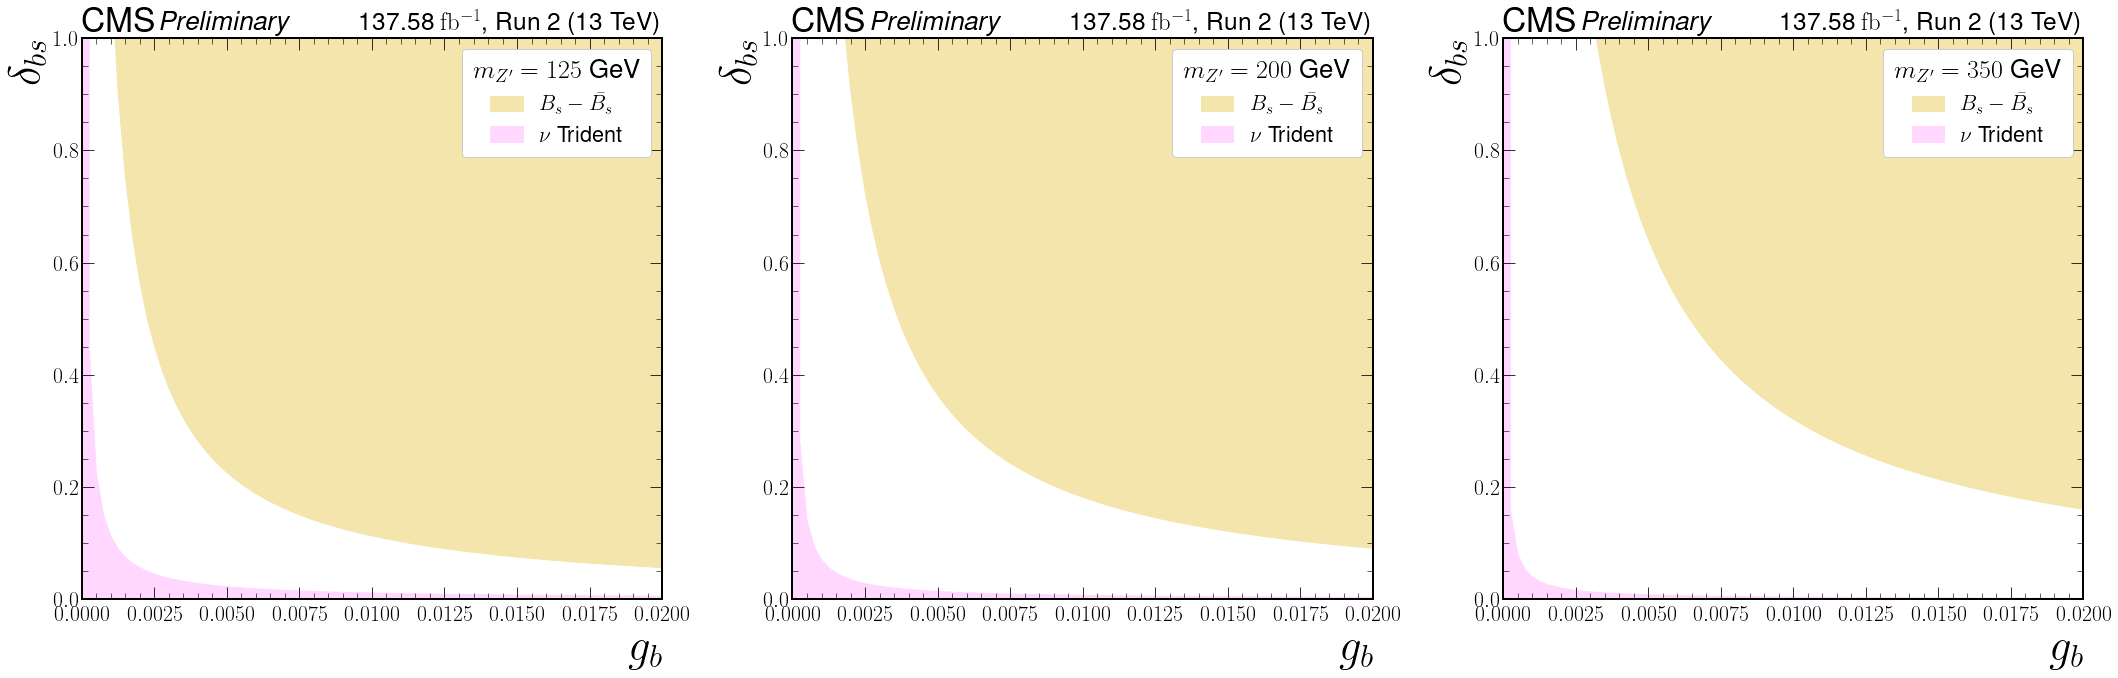

In [267]:

#draw example other experiment limits
fig, axs = plt.subplots(1, 3, figsize=(30,10))
for mass, ax in zip([125, 200, 350], axs):

    other_exp = draw_other_experiments(ax, mass)
    
    legend_opts = {
                "facecolor": 'white',
                "framealpha": 1,
                "frameon": True,
                "title":"$m_{{Z'}} = {}$ GeV".format(mass),
                "loc": 'upper right'
            }
    cms_format_fig("Run 2", ax, "\emph{Preliminary}")
    ax.legend(**legend_opts)
    ax.set_xlabel('$g_b$', fontsize=45)
    ax.set_ylabel('$\\delta_{bs}$', fontsize=45)
    ax.set_ylim([0,1])
    ax.set_xlim([0,.02])
fig.savefig('{}/limits_gb_dbs_by_mass_reg/other_experiments.pdf'.format(output_dir))
    

In [268]:
'{}/limits_gb_dbs_by_mass_reg/other_experiments.pdf'.format(output_dir, mass)

'/eos/cms/store/group/phys_exotica/bffZprime/assets_june_23/limits_gb_dbs_by_mass_reg/other_experiments.pdf'

21 SR1 200.0


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/general/limit_utils.py:164: RuntimeWarning: invalid value encountered in double_scalars
  return c1*(1+c2*x**.5)


SR1 2016 200.0


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/general/limit_utils.py:164: RuntimeWarning: invalid value encountered in double_scalars
  return c1*(1+c2*x**.5)


14.774859999999997 20.990581999999993 30.51795166666666
[[array([[1.20000000e+00, 7.64100436e-03],
         [1.19343434e+00, 7.66425829e-03],
         [1.18990126e+00, 7.67676768e-03],
         ...,
         [3.91744158e-02, 4.04040404e-04],
         [3.88807675e-02, 2.02020202e-04],
         [3.85674832e-02, 0.00000000e+00]])]
 [array([[1.20000000e+00, 6.85340292e-03],
         [1.19458243e+00, 6.86868687e-03],
         [1.19343434e+00, 6.87242495e-03],
         ...,
         [6.68477819e-02, 4.04040404e-04],
         [6.65456015e-02, 2.02020202e-04],
         [6.62226896e-02, 0.00000000e+00]])]
 [array([[1.20000000e+00, 6.16774390e-03],
         [1.19343434e+00, 6.18362018e-03],
         [1.18686869e+00, 6.19942479e-03],
         [1.18030303e+00, 6.21515810e-03],
         [1.17373737e+00, 6.23082050e-03],
         [1.16717172e+00, 6.24641242e-03],
         [1.16060606e+00, 6.26193429e-03],
         [1.16031462e+00, 6.26262626e-03],
         [1.15404040e+00, 6.28027563e-03],
         

/tmp/rymuelle/ipykernel_30170/400420250.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allsegs = np.array(contors.allsegs)
/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/general/limit_utils.py:164: RuntimeWarning: invalid value encountered in double_scalars
  return c1*(1+c2*x**.5)


16.904721 24.041626000000008 35.00717333333334
[list([array([[1.20000000e+00, 7.32161046e-03],
        [1.19343434e+00, 7.34482571e-03],
        [1.18686869e+00, 7.36793032e-03],
        ...,
        [4.91845216e-02, 4.04040404e-04],
        [4.88774294e-02, 2.02020202e-04],
        [4.85497561e-02, 0.00000000e+00]])])
 list([array([[1.20000000e+00, 6.59029764e-03],
        [1.19343434e+00, 6.60823587e-03],
        [1.18686869e+00, 6.62609155e-03],
        ...,
        [7.90247027e-02, 4.04040404e-04],
        [7.87371451e-02, 2.02020202e-04],
        [7.84295055e-02, 0.00000000e+00]])])
 list([array([[1.18226492e+00, 0.00000000e+00],
        [1.18686869e+00, 9.64069144e-06],
        [1.19343434e+00, 2.34129307e-05],
        [1.20000000e+00, 3.72452788e-05]]), array([[1.20000000e+00, 5.94734405e-03],
        [1.19343434e+00, 5.96227530e-03],
        [1.18686869e+00, 5.97713976e-03],
        [1.18030303e+00, 5.99193784e-03],
        [1.17373737e+00, 6.00666994e-03],
        [1.16717172e

/tmp/rymuelle/ipykernel_30170/400420250.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allsegs = np.array(contors.allsegs)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

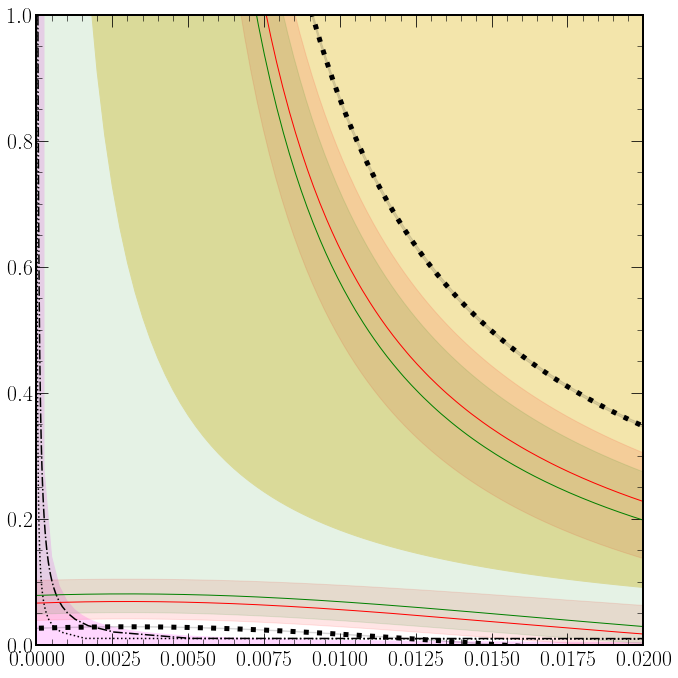

In [271]:
gbs=Bins(np.linspace(0., .04, 200))
dbses = Bins(np.linspace(-0.1, 1.2, 200))
sys_dir = ['down', 'nom', 'up']
gb_dbs_const_exclusion = []
for i, (reg, mass) in limit_df[['nJets', 'mass']].drop_duplicates().iterrows():
    if mass not in [200]: continue
    
    if reg not in ["SR1"]: continue
    print(i, reg, mass)
    start = perf_counter()
    fig, ax = plt.subplots()
    ax.set_ylim([0,1])
    ax.set_xlim([0,.02])
    _ = draw_gmu_curve(ax, mass, percent=10, color='black',linestyle=':', 
                                    zorder=1, label='width $<$ {}\%'.format(10))
    gmu_cons_curve = draw_gmu_curve(ax, mass, percent=1, color='black',linestyle='-.', 
                                    zorder=1, label='width $<$ {}\%'.format(1))
    other_exp = draw_other_experiments(ax, mass)
    # inclusive curve, both methods here seem to work and return the same result
    if mass >= 200:
        draw_gb_dbs_curve_inclusive(_, '201X', mass, ax, gbs, dbses, 
                                color='black', linestyle=':', linewidth=5, label='JHEP 07 (2021) 208')
        #draw_inclusive(ax, mass, color='black', linestyle=':', linewidth=5, label='JHEP 07 (2021) 208')
    
    #draw exclusion curves
    colors = ['red', 'green', 'blue', 'darkorchid']
    eras = [2016, 2017, 2018, '201X']
    for _color, _era in zip(colors, eras):
        label = _era if _era != '201X' else 'Run 2'
        linewidth = 1 if _era != '201X' else 3
        print(reg, _era, mass)
        curve = draw_gb_dbs_curve(reg, _era, mass, ax, gbs, dbses, label=label, color=_color, linewidth=linewidth)
        # compute intersecitons
        if _era =='201X':
            intesection_ty = find_intersections(other_exp['gb'], other_exp['ty'], curve)
            intesection_gmu = find_intersections(gmu_cons_curve['gb'], gmu_cons_curve['dbs'], curve)
            gb_limits = np.min([intesection_ty[:,0], intesection_gmu[:,0]], axis=0)
            dbs_limits = np.max([intesection_ty[:,1], intesection_gmu[:,1]], axis=0)
            
            ax.scatter(gb_limits, dbs_limits, marker="*", color='black')
            gb_limits_dict_ty = {'gb_'+k: v for k,v in zip(sys_dir,np.sort(intesection_ty[:,0]))}
            dbs_limits_dict_ty = {'dbs_'+k: v for k,v in zip(sys_dir,np.sort(intesection_ty[:,1]))}
            gb_limits_dict_gmu = {'gb_gmu_'+k: v for k,v in zip(sys_dir,np.sort(intesection_gmu[:,0]))}
            dbs_limits_dict_gmu = {'dbs_gmu_'+k: v for k,v in zip(sys_dir,np.sort(intesection_gmu[:,1]))}
            ty = (intesection_ty[:,1] > intesection_gmu[:,1]).all()
            print(reg)
            gb_dbs_const_exclusion.append({"ty": ty, "era": _era, "reg": reg, "mass": mass, 
                                           **gb_limits_dict_ty, **dbs_limits_dict_ty, 
                                           **gb_limits_dict_gmu, **dbs_limits_dict_gmu})

    #format plot
    ax.set_ylim([0,1])
    ax.set_xlim([0,.02])
    legend_opts = {
                "facecolor": 'white',
                "framealpha": 1,
                "frameon": True,
                "title":"$m_{{Z'}} = {}$ GeV".format(mass),
                "loc": 'upper right'
            }
    _era = era if era != '201X' else 'Run 2'
   
    cms_format_fig(str(_era), ax, "\emph{Preliminary}")
    ax.legend(**legend_opts)
    ax.set_xlabel('$g_b$', fontsize=45)
    ax.set_ylabel('$\\delta_{bs}$', fontsize=45)
    # make ticks bigger
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #shift tick labels down a bit
    [x.set_y(-.01) for x in ax.xaxis.get_majorticklabels()]
    
    fig.savefig('{}/limits_gb_dbs_by_mass_reg/gb_dbs_lim_{}_{}.pdf'.format(output_dir, mass, reg))
    fig.savefig('{}/limits_gb_dbs_by_mass_reg/gb_dbs_lim_{}_{}.png'.format(output_dir, mass, reg)) 
    
    #draw comparision curves with old limits
    if mass in []:
        for _color, _era in zip(colors, eras):
            label = _era if _era != '201X' else 'Run 2'
            label = str(label) +" old"
            curve = draw_gb_dbs_curve(reg, _era, mass, ax, gbs, dbses, _limit_df=limit_df_old, 
                                      label=label, color=_color, linewidth=linewidth,
                                     ls=':')

    if i==0: plt.show()
    plt.show()
    plt.clf()
    end = perf_counter()
    print("{:.2f} seconds".format(end-start))


In [ ]:
fig, ax = plt.subplots()
counts, gb_dbs_grid = make_fb_grid(reg, era, mass, gbs, dbses)
contors = ax.contour(counts.T,
                     extent=[
                     gbs.bin_edges.min(),gbs.bin_edges.max(),
                     dbses.bin_edges.min(),dbses.bin_edges.max()],
                     linewidths=3, 
                     levels=[15, 35])

allsegs = np.array(contors.allsegs)
#contors.allsegs


/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/general/limit_utils.py:164: RuntimeWarning: invalid value encountered in double_scalars
  return c1*(1+c2*x**.5)
/tmp/rymuelle/ipykernel_30170/143209607.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allsegs = np.array(contors.allsegs)


[array([[1.18240504e+00, 0.00000000e+00],
        [1.18686869e+00, 9.34727693e-06],
        [1.19343434e+00, 2.31168913e-05],
        [1.20000000e+00, 3.69465973e-05]]),
 array([[1.20000000e+00, 5.94766650e-03],
        [1.19343434e+00, 5.96259488e-03],
        [1.18686869e+00, 5.97745649e-03],
        [1.18030303e+00, 5.99225174e-03],
        [1.17373737e+00, 6.00698102e-03],
        [1.16717172e+00, 6.02164477e-03],
        [1.16060606e+00, 6.03624343e-03],
        [1.15404040e+00, 6.05077747e-03],
        [1.14959375e+00, 6.06060606e-03],
        [1.14747475e+00, 6.06621571e-03],
        [1.14090909e+00, 6.08362373e-03],
        [1.13434343e+00, 6.10094944e-03],
        [1.12777778e+00, 6.11819330e-03],
        [1.12121212e+00, 6.13535582e-03],
        [1.11464646e+00, 6.15243750e-03],
        [1.10808081e+00, 6.16943891e-03],
        [1.10151515e+00, 6.18636059e-03],
        [1.09494949e+00, 6.20320314e-03],
        [1.08838384e+00, 6.21996718e-03],
        [1.08181818e+00, 6.23665

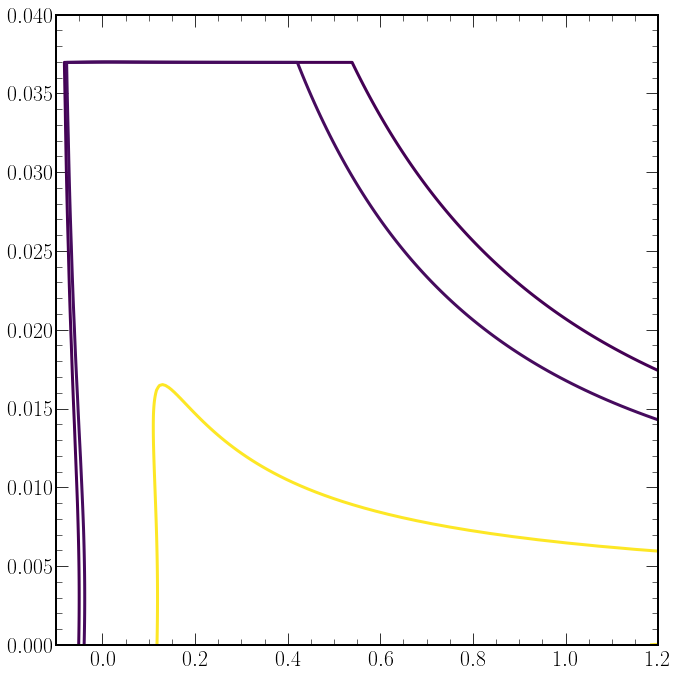

In [252]:
fig, ax = plt.subplots()
counts, gb_dbs_grid = make_fb_grid(reg, era, mass, gbs, dbses)
contors = ax.contour(counts.T,
                     extent=[dbses.bin_edges.min(),dbses.bin_edges.max(),
                     gbs.bin_edges.min(),gbs.bin_edges.max()],
                     linewidths=3, 
                     levels=[2,3,35])

allsegs = np.array(contors.allsegs)
allsegs[2]

In [97]:
def draw_gb_dbs_curve(reg, era, mass, ax, gbs, dbses, _limit_df=limit_df, **kwargs):
    mdf = _limit_df[(_limit_df.nJets==reg) &
                  (_limit_df.era==era) &
                  (_limit_df.mass==mass)]
    print(mdf)
    counts, gb_dbs_grid = make_fb_grid(reg, era, mass, gbs, dbses)

    down, nom, up = interpolate_fb(mdf, dbses.calc_bin_centers() )
    allsegs = gb_dbs_curve(counts, dbses, gbs, np.nanmean(down), np.nanmean(nom), np.nanmean(up), show=False)
    draw_curve(ax, *allsegs, **kwargs)
    return allsegs

In [34]:
def make_fb_grid(reg, era, mass, gbs, dbses, show = False, weights = 'xsec'):
    gb_dbs_grid = make_gb_dbs_grid(reg, era, mass, gbs=gbs.calc_bin_centers(), dbses=dbses.calc_bin_centers())
    gb_dbs_grid.loc[gb_dbs_grid.dbs>1, 'xsec']= -200
    #gb_dbs_grid.loc[gb_dbs_grid.gb== min(gb_dbs_grid.gb), 'xsec']=  -200 

    fig, ax = plt.subplots()
    counts,ybins,xbins,image = ax.hist2d(gb_dbs_grid.gb, gb_dbs_grid.dbs, weights=gb_dbs_grid[weights], 
                                     bins = (gbs.bin_edges, dbses.bin_edges))
    # hack to elimnate splitting of contours
    #counts[-1,:]=-100
    if not show: plt.close(fig)
    return counts, gb_dbs_grid


In [35]:
from IPython.display import HTML

In [36]:
HTML(limit_df[(limit_df.dbs==1.0) & 
              (limit_df.era=='201X') &
              (limit_df.nJets=='SR1') &
              (limit_df.mass.isin([125,202,350]))][['mass', 'nJets', '16.0', '50.0', '84.0']].round(1).to_html(index=False))

mass,nJets,16.0,50.0,84.0
125.0,SR1,0.0,0.0,0.0
350.0,SR1,0.0,0.0,0.0


In [37]:
HTML(limit_df[(limit_df.dbs==1.0) & 
              (limit_df.era=='201X') &
              (limit_df.nJets=='SR2') &
              (limit_df.mass.isin([125,202,350]))][['mass', 'nJets', '16.0', '50.0', '84.0']].round(1).to_html(index=False))

mass,nJets,16.0,50.0,84.0
350.0,SR2,0.0,0.1,0.1
125.0,SR2,0.0,0.0,0.0


In [38]:
print(limit_df[(limit_df.dbs==1.0) & 
              (limit_df.era=='201X') &
              (limit_df.nJets=='SR2') &
              (limit_df.mass.isin([125,202,350]))][['mass', 'nJets', '16.0', '50.0', '84.0']].round(1).to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>mass</th>
      <th>nJets</th>
      <th>16.0</th>
      <th>50.0</th>
      <th>84.0</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>350.0</td>
      <td>SR2</td>
      <td>0.0</td>
      <td>0.1</td>
      <td>0.1</td>
    </tr>
    <tr>
      <td>125.0</td>
      <td>SR2</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
    </tr>
  </tbody>
</table>


In [40]:
def interpolate_counts(mdf, dbses):
    org_dbs = mdf['dbs']  
    nom = mdf['n_50.0'] 
    down = mdf['n_16.0']  
    up = mdf['n_84.0'] 

    nom_int = interp1d(org_dbs, nom, fill_value="extrapolate")
    up_int = interp1d(org_dbs, up, fill_value="extrapolate")
    down_int = interp1d(org_dbs, down, fill_value="extrapolate")
    return down_int(dbses), nom_int(dbses), up_int(dbses)

In [41]:
# model independant curves

In [42]:
#compute fb equivelents
limit_cols = limit_df.filter(regex="[0-9]+\.[0-9]+").columns
xsec_lim_cols = [l+'_fb' for l in limit_cols]
nevents = limit_df[limit_cols]

limit_df['pred_acceptance'] = limit_df.apply(lambda x: acceptance_model(x, x.nJets), axis=1)
aceptance = limit_df['pred_acceptance']

def map_lumi(x):
    era = str(x.era)
    if era == '201X' : era='16-18'
    return lumi_dict[era]
lumi = limit_df.apply(map_lumi, axis=1)
limit_df[xsec_lim_cols] = nevents.divide(aceptance*lumi, axis=0)

201X SRX
[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

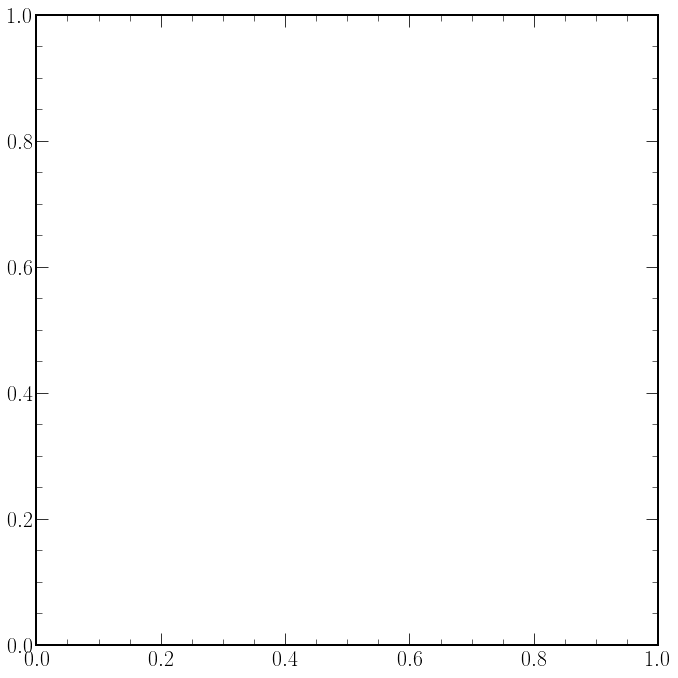

In [46]:
dbs = 0.04
for era in [ '201X']:
    for reg in ['SRX']:
        print(era, reg)
        tdf = limit_df[(limit_df.era==era) & (limit_df.nJets==reg) & (limit_df.dbs==dbs)  & (limit_df.mass<=400)]
        masses = tdf.mass.unique()
        masses = list(sorted(masses))
        print(masses)
        limits_list = []
        for mass in masses:
            mtdf = tdf[tdf.mass==mass]
            mtdf = mtdf.mean(axis=0)
            limits = mtdf[['2.5_fb', '16.0_fb',  '50.0_fb', '84.0_fb', '97.5_fb']].values
            limits_list.append(limits)
        fig, ax = plt.subplots(1)
        ax.fill_between(masses, np.array(limits_list)[:,0], np.array(limits_list)[:,4], color='yellow')
        ax.fill_between(masses, np.array(limits_list)[:,1], np.array(limits_list)[:,3], color='green')
        ax.plot(masses, np.array(limits_list)[:,2], color='black', ls=':')
        
        ax.set_yscale('log')
        ax.set_xlabel('DiLepMass [GeV]', fontsize=45)        
        ax.set_ylabel("$\sigma (pp \\rightarrow Z' \\rightarrow \mu\mu)$ [fb]", fontsize=45)
        # make ticks bigger
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.tick_params(axis='both', which='minor', labelsize=30)
        
        if era=='201X': era='16-18'
        cms_format_fig(str(era), ax,"\emph{Preliminary}")
        
        ax.set_ylim(bottom=1e-1, top=1e1)
        break

In [ ]:

dbs = 0.04
for era in [ 2016, 2017, 2018, '201X']:
    for reg in ['SR1', "SR2", "Comb."]:
        print(era, reg)
        #if reg=="SRX": continue
        
        lera= era
        if era=='201X': lera='16-18'
            
        lumi = lumi_dict[str(lera)]
        tdf = limit_df[(limit_df.era==era) & (limit_df.nJets==reg)  & (limit_df.mass<=350)]
        masses = tdf.mass.unique()
        masses = list(sorted(masses))
        masses = [125, 150, 175, 200, 350]
        print(masses)
        limits_list = []
        for mass in masses:
            mtdf = tdf[tdf.mass==mass]
            mtdf = mtdf.mean(axis=0)
            limits = mtdf[['fb_2.5', 'fb_16.0',  'fb_50.0', 'fb_84.0', 'fb_97.5']].values
            limits_list.append(limits)
        fig, ax = plt.subplots(1)
        ax.fill_between(masses, np.array(limits_list)[:,0], np.array(limits_list)[:,4], color='yellow', label='$\pm 2$ std.deviation')
        ax.fill_between(masses, np.array(limits_list)[:,1], np.array(limits_list)[:,3], color='green',
                       label='$\pm 1$ std.deviation')
        print(np.array(limits_list)[:,2])
        ax.plot(masses, np.array(limits_list)[:,2], color='black', ls=':',
               label='Expected')
        
        ax.set_yscale('log')
        labelsize = 30
        ax.set_xlabel('$m_{\ell\ell}$ [GeV]', fontsize=labelsize)
        
        if reg =='SR1':
            ax.set_ylabel("$\sigma \\cdot Br(bZ' \\rightarrow  \mu\mu) \\cdot A$ [fb]", fontsize=labelsize)
        if reg =='SR2':
            ax.set_ylabel("$\sigma\\cdot Br((b+j/b)Z' \\rightarrow  \mu\mu) \\cdot A$ [fb]", fontsize=labelsize)
        if reg =='Comb.':
            ax.set_ylabel("$\sigma\\cdot Br((b + (b+j/b)) Z' \\rightarrow  \mu\mu) \\cdot A$ [fb]", fontsize=labelsize)
        # make ticks bigger
        ax.set_xticks([125,175,225,275,325])
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.tick_params(axis='both', which='minor', labelsize=30)
        cera = str(era)    
        if era=='201X': cera='Run 2'
        cms_format_fig(str(cera), ax, "\emph{Preliminary}")
        ax.legend()
        ax.set_ylim(bottom=2e-2, top=200e0)
        fig.savefig('{}/model_ind/xsec_br_a_{}_{}.pdf'.format(output_dir, era, reg))

2016 SR1
[125.0, 150.0, 175.0, 200.0, 250.0, 300.0, 350.0]
2016 SR2
[125.0, 150.0, 175.0, 200.0, 250.0, 300.0, 350.0]
2016 SRX
[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

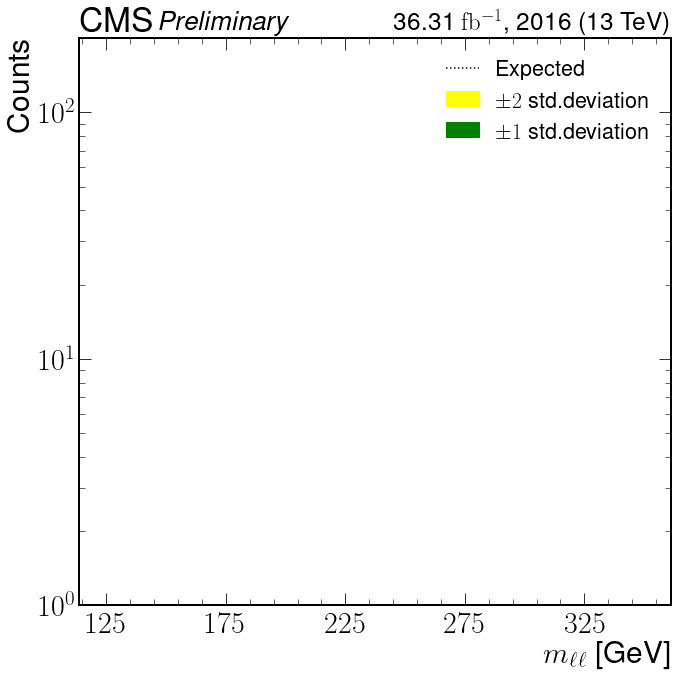

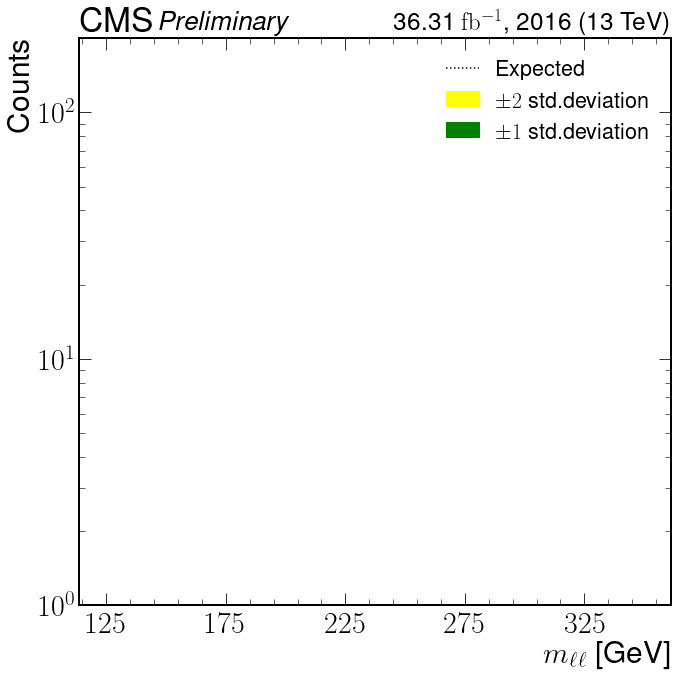

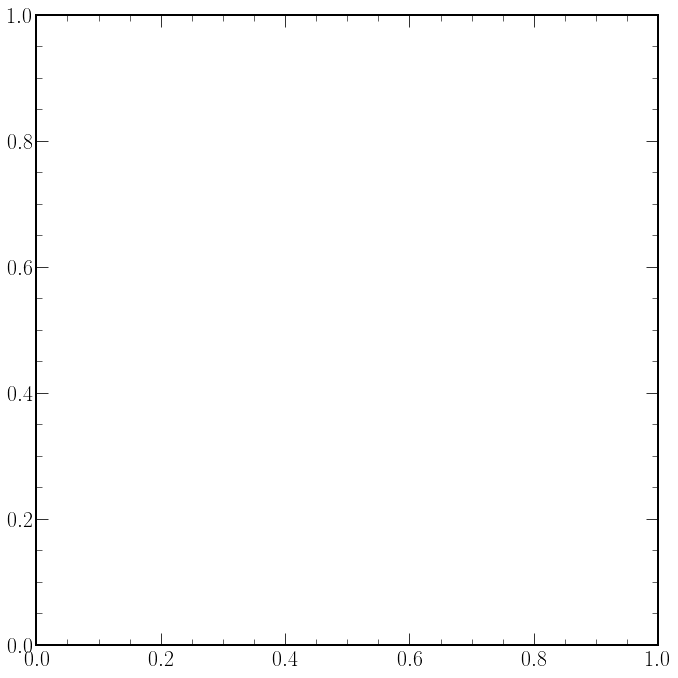

In [47]:
# count limits
dbs = 0.04
for era in [ 2016, 2017, 2018, '201X']:
    for reg in ['SR1', "SR2", "SRX"]:
        print(era, reg)
        #if reg=="SRX": continue
        
        lera= era
        if era=='201X': lera='16-18'
            
        lumi = lumi_dict[str(lera)]
        tdf = limit_df[(limit_df.era==era) & (limit_df.nJets==reg)  & (limit_df.mass<=350)]
        masses = tdf.mass.unique()
        masses = list(sorted(masses))
        print(masses)
        limits_list = []
        for mass in masses:
            mtdf = tdf[tdf.mass==mass]
            mtdf = mtdf.mean(axis=0)
            limits = mtdf[['2.5', '16.0',  '50.0', '84.0', '97.5']].values
            limits_list.append(limits)
        fig, ax = plt.subplots(1)
        ax.fill_between(masses, np.array(limits_list)[:,0], np.array(limits_list)[:,4], color='yellow', label='$\pm 2$ std.deviation')
        ax.fill_between(masses, np.array(limits_list)[:,1], np.array(limits_list)[:,3], color='green',
                       label='$\pm 1$ std.deviation')
        ax.plot(masses, np.array(limits_list)[:,2], color='black', ls=':',
               label='Expected')
        
        ax.set_yscale('log')
        labelsize = 30
        ax.set_xlabel('$m_{\ell\ell}$ [GeV]', fontsize=labelsize)
        
        if reg =='SR1':
            ax.set_ylabel("Counts", fontsize=labelsize)
        if reg =='SR2':
            ax.set_ylabel("Counts", fontsize=labelsize)
        if reg =='SRX':
            ax.set_ylabel("Counts", fontsize=labelsize)
        # make ticks bigger
        ax.set_xticks([125,175,225,275,325])
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.tick_params(axis='both', which='minor', labelsize=30)
        cera = str(era)    
        if era=='201X': cera='Run 2'
        cms_format_fig(str(cera), ax,"\emph{Preliminary}")
        ax.legend()
        ax.set_ylim(bottom=1, top=200)
        fig.savefig('{}/model_ind/xsec_br_a_{}_{}_Counts.pdf'.format(output_dir, era, reg))

In [ ]:
from src.assets.regions import region_and_label

In [ ]:
region_and_label

NameError: name 'region_and_label' is not defined

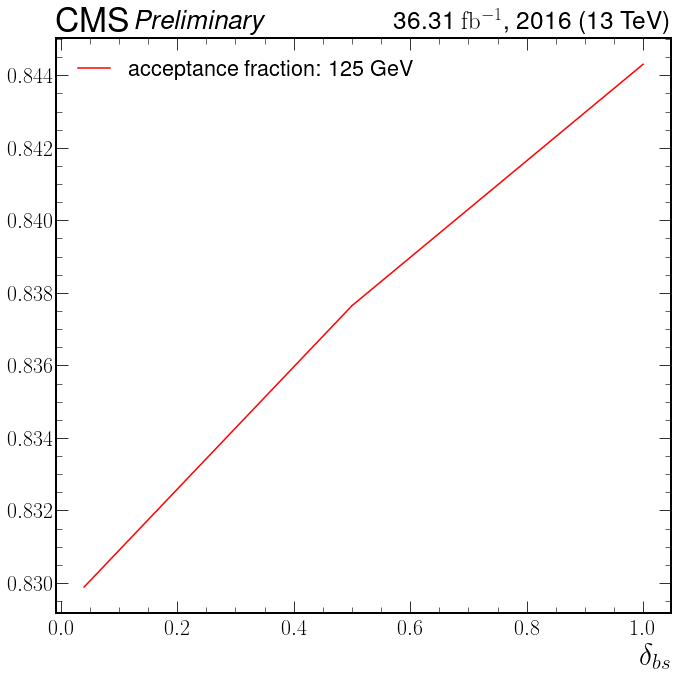

In [45]:
# acceptance fraction

masses = limit_df.mass.unique()

for mass in [125, 202, 350]:
    sr1  = limit_df[(limit_df.mass==mass) & (limit_df.nJets=='SR1') & (limit_df.era==2016)].sort_values('dbs')
    sr2  = limit_df[(limit_df.mass==mass) & (limit_df.nJets=='SR2') & (limit_df.era==2016)].sort_values('dbs')
    a1 = sr1.pred_acceptance.to_numpy()
    a2 = sr2.pred_acceptance.to_numpy()   
    afrac = a1/(a1+a2)
    
    fig, ax = plt.subplots(1)
    ax.plot(sr1.dbs, afrac, label='acceptance fraction: {} GeV'.format(mass), color='red')
    cms_format_fig(str(cera), ax ,"\emph{Preliminary}")
    ax.legend()
    #ax.set_ylim(0,1)
    ax.set_xlabel('$\delta_{bs}$', fontsize=labelsize)
    ax.set_ylabel('${}/({}+{}$)'.format(region_and_label['SR1'],region_and_label['SR1'],region_and_label['SR2']),
                  fontsize=labelsize)
    fig.savefig('{}/model_indacc_fraction_{}_{}.pdf'.format(output_dir, era, mass))

In [ ]:
from src.plotting_tools.colors import color_fader

In [ ]:
sorted(masses)

In [ ]:
167-125 +378

In [ ]:
mass_sorted = sorted(masses)
mass_sorted = mass_sorted[::6]
mass_sorted.append(400)
colors = [color_fader('red','blue',mix=float(i)/len(mass_sorted)) for i in range(len(mass_sorted))]


In [ ]:
# acceptance fraction
fig, ax = plt.subplots(1)
masses = limit_df.mass.unique()

color_fader
for c, mass in zip(colors, mass_sorted):
    sr1  = limit_df[(limit_df.mass==mass) & (limit_df.nJets=='SR1') & (limit_df.era==2016)].sort_values('dbs')
    sr2  = limit_df[(limit_df.mass==mass) & (limit_df.nJets=='SR2') & (limit_df.era==2016)].sort_values('dbs')
    a1 = sr1.pred_acceptance.to_numpy()
    a2 = sr2.pred_acceptance.to_numpy()   
    afrac = a1/(a1+a2)
    
   
    ax.plot(sr1.dbs, afrac, label='{} GeV'.format(mass), color=c)
    cms_format_fig(str(cera), ax)
ax.legend(ncol=2)
ax.set_ylim(.7,.95)
ax.set_xlabel('$\delta_{bs}$', fontsize=labelsize)
ax.set_ylabel('${}/({}+{}$)'.format(region_and_label['SR1'],region_and_label['SR1'],region_and_label['SR2']),
                  fontsize=labelsize)
fig.savefig('{}/model_ind/acc_fraction_{}.pdf'.format(output_dir, era, mass))

In [ ]:
def make_bins(arr):
    '''assumes linear'''
    delta = arr[1]-arr[0]
    nbins = len(arr)
    bottom, top = arr[0]-delta/2, arr[-1]+delta/2
    #arr = arr.append(arr[-1]+delta)
    return np.append(arr, [arr[-1]+delta])-delta/2


In [ ]:
sr1.mass.unique(), make_bins(sr1.mass.unique())

In [ ]:
#2d plot

sr1  = limit_df[(limit_df.nJets=='SR1') & (limit_df.era==2016)].sort_values('dbs')
sr2  = limit_df[(limit_df.nJets=='SR2') & (limit_df.era==2016)].sort_values('dbs')

mass_bins =  make_bins(sorted(sr1.mass.unique()))
dbs_bins = make_bins(sorted(sr1.dbs.unique()))
sr1_hist = plt.hist2d(sr1.mass, sr1.dbs, weights=sr1.pred_acceptance,  bins=(mass_bins, dbs_bins))
sr2_hist = plt.hist2d(sr2.mass, sr2.dbs, weights=sr2.pred_acceptance,  bins=(mass_bins, dbs_bins))
acc_frac = sr1_hist[0]/(sr1_hist[0]+sr2_hist[0])

In [ ]:
plt.yticks()[0], plt.xticks()[0]

In [ ]:
dir(plt)

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(acc_frac.T, cmap="copper_r", aspect = 3)
ax.set_xticklabels(sorted(sr1.mass.unique()))
plt.colorbar(im)


In [ ]:
 matplotlib.pyplot.hist2d(x, y, bins=10, range=None, density=False, weights=None, cmin=None, cmax=None, *, data=None, **kwargs)[source]

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
data2D = np.random.random((50, 50))
im = plt.imshow(data2D, cmap="copper_r")
plt.colorbar(im)
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
# Width and height of the figure
plt.figure(figsize=(14,7))
# Title
plt.title(“Average Arrival Delay of Airlines, by Month”, )
# Heatmap which shows the average arrival delay for airlines by month
sns.heatmap(data=flights, annot=True, cmap=’RdYlGn’)
# Label of horizontal axis
plt.xlabel(“Airlines”)

In [37]:
# gb dbs constant exclusion plots

In [38]:
intersection_df = pd.DataFrame(gb_dbs_const_exclusion)

In [39]:
intersection_df

,ty,era,reg,mass,gb_down,gb_nom,gb_up,dbs_down,dbs_nom,dbs_up,gb_gmu_down,gb_gmu_nom,gb_gmu_up,dbs_gmu_down,dbs_gmu_nom,dbs_gmu_up
0,True,201X,SR1,125,0.001222,0.001469,0.001790,0.062901,0.076776,0.092416,0.001218,0.001461,0.001776,0.012349,0.015572,0.018052
1,True,201X,SR1,132,0.001164,0.001400,0.001702,0.062717,0.076558,0.092441,0.001161,0.001394,0.001691,0.015008,0.017728,0.019863
2,True,201X,SR1,139,0.001074,0.001374,0.001668,0.060863,0.074105,0.095030,0.001073,0.001368,0.001658,0.016802,0.019194,0.024281
3,True,201X,SR1,146,0.001138,0.001369,0.001662,0.058192,0.070834,0.085549,0.001136,0.001363,0.001651,0.018133,0.020293,0.025341
4,True,201X,SR1,153,0.001151,0.001386,0.001682,0.054812,0.066748,0.080673,0.001149,0.001380,0.001671,0.019101,0.022648,0.027343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,False,201X,SR2,357,0.004458,0.005313,0.006382,0.006165,0.007405,0.008827,0.004494,0.005349,0.006420,0.026727,0.031050,0.037422
74,False,201X,SR2,364,0.004573,0.005451,0.006546,0.005893,0.007078,0.008439,0.004612,0.005490,0.006587,0.027042,0.031563,0.037854
75,False,201X,SR2,371,0.004652,0.005545,0.006668,0.005677,0.006826,0.008140,0.004693,0.005586,0.006711,0.027496,0.032370,0.038532
76,False,201X,SR2,378,0.004743,0.005653,0.006798,0.005465,0.006573,0.007832,0.004785,0.005696,0.006843,0.027910,0.033052,0.039105


In [40]:
def draw_const_exclusion(ax, _tdf, key,  _c, hatch = '', label='', **kwargs):
    ax.plot(_tdf.mass,_tdf[key+'nom'], color = _c, **kwargs)
    ax.fill_between(_tdf.mass, _tdf[key+'down'], _tdf[key+'up'], color=_c, alpha=.5, hatch=hatch, label=label)

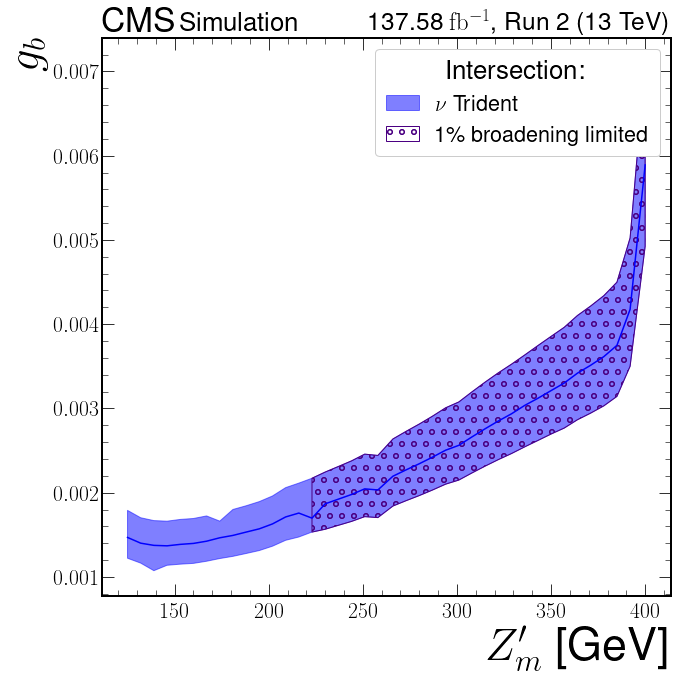

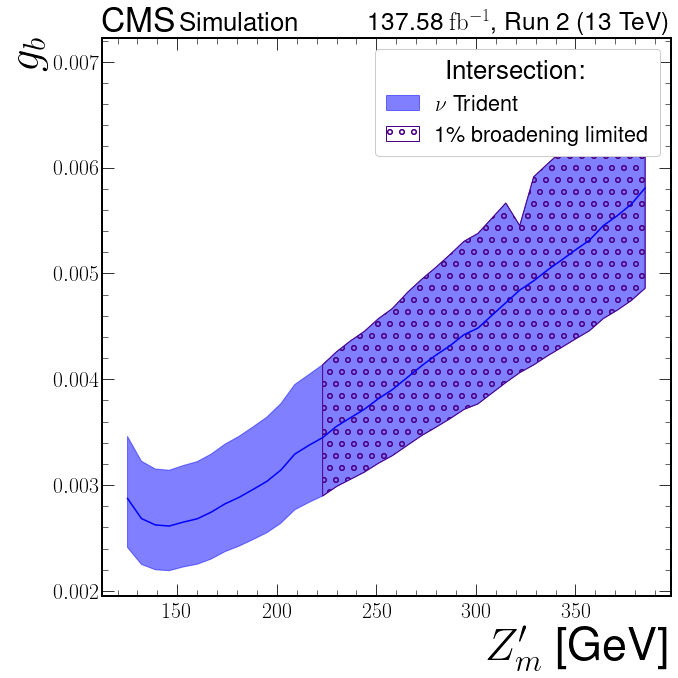

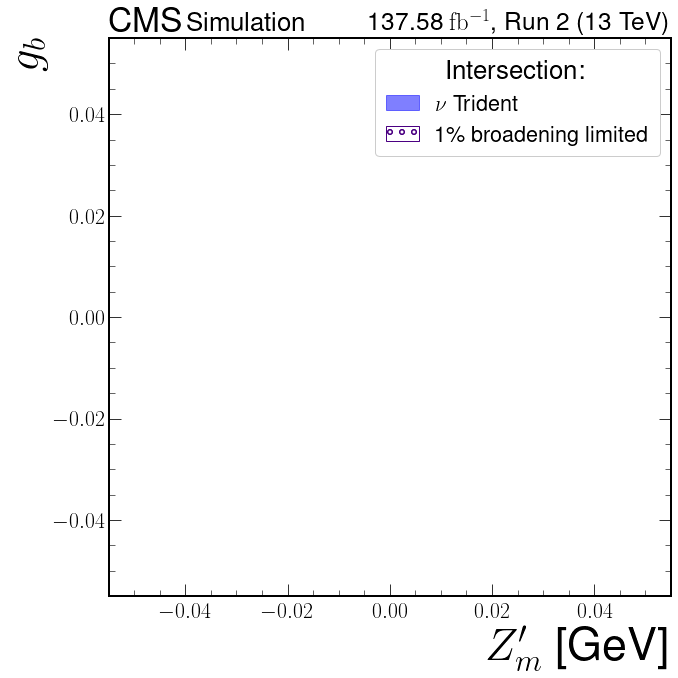

In [41]:
for reg in ['SR1', 'SR2', 'SRX']:
    fig, ax = plt.subplots()
    legend_opts = {
                "facecolor": 'white',
                "framealpha": 1,
                "frameon": True,
                "title": "Intersection:"
            }
    cms_format_fig('Run 2', ax)
    ax.legend(**legend_opts)
    ax.set_ylabel('$g_b$', fontsize=45)
    ax.set_xlabel("$Z'_m$ [GeV]", fontsize=45)
    
    tdf = intersection_df[(intersection_df.reg==reg)].sort_values('mass')
    draw_const_exclusion(ax, tdf, 'gb_', 'blue', label='$\\nu$ Trident')
    
    gmu_limited = tdf.dbs_gmu_nom> tdf.dbs_nom

    tdf = intersection_df[(intersection_df.reg==reg)& gmu_limited].sort_values('mass')
    ax.fill_between(tdf.mass, tdf['gb_'+'down'], tdf['gb_'+'up'], color='none',edgecolor="indigo", 
                    hatch='o', label='1\% broadening limited')
    #draw_const_exclusion(ax, tdf, 'gb_', 'blue', hatch='//', label='1\% broadening limited')
    
    #tdf = intersection_df[(intersection_df.reg==reg)].sort_values('mass')
    #draw_const_exclusion(ax, tdf, 'gb_gmu_', 'red', label='1\% width intersction')
    
    ax.legend(**legend_opts)
    fig.savefig('{}/limits_gb_dbs_by_mass_reg/gb_min_excluded_{}.pdf'.format(output_dir, reg))  

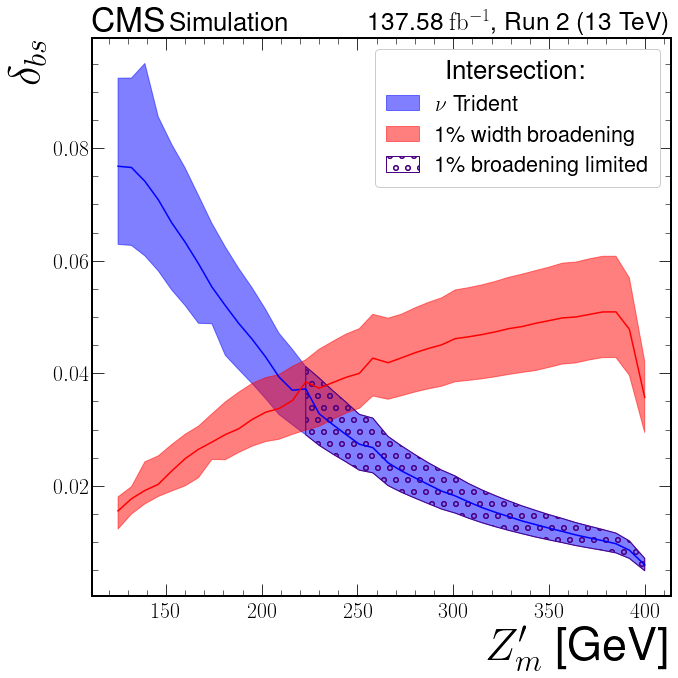

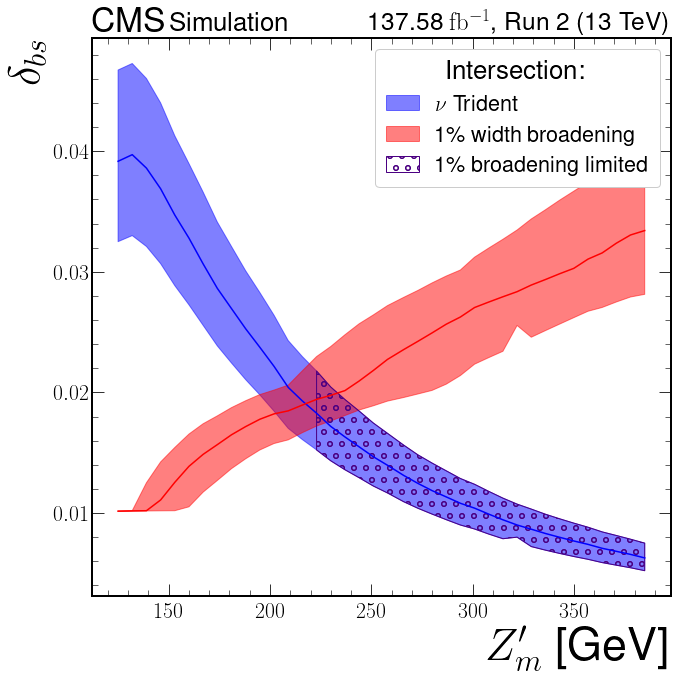

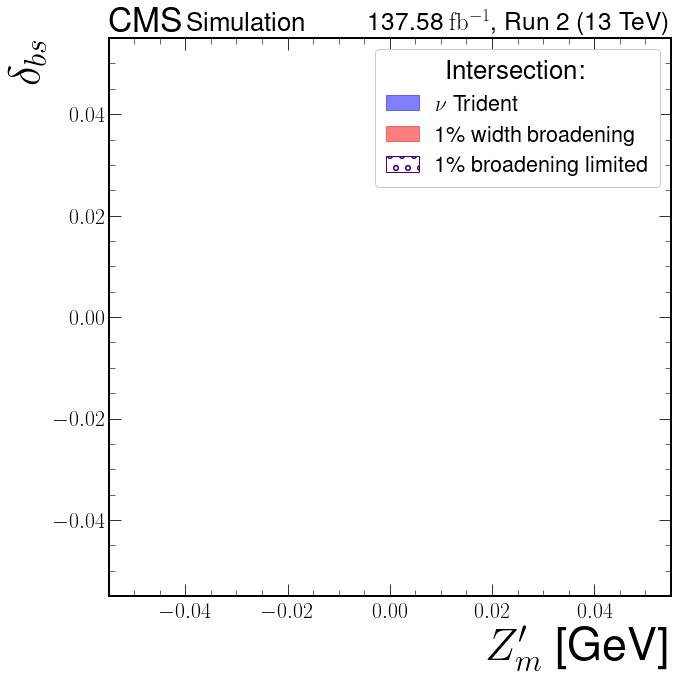

In [42]:
for reg in ['SR1', 'SR2', 'SRX']:
    fig, ax = plt.subplots()
    legend_opts = {
                "facecolor": 'white',
                "framealpha": 1,
                "frameon": True,
         "title": "Intersection:"
            }
    cms_format_fig('Run 2', ax)
    ax.set_ylabel('$\delta_{bs}$', fontsize=45)
    ax.set_xlabel("$Z'_m$ [GeV]", fontsize=45)
    tdf = intersection_df[(intersection_df.reg==reg) ].sort_values('mass')
    draw_const_exclusion(ax, tdf, 'dbs_', 'blue', label='$\\nu$ Trident')
    tdf = intersection_df[(intersection_df.reg==reg) ].sort_values('mass')
    draw_const_exclusion(ax, tdf, 'dbs_gmu_', 'red', label='1\% width broadening')
    
    gmu_limited = tdf.dbs_gmu_nom>= tdf.dbs_nom
    tdf = intersection_df[(intersection_df.reg==reg)& gmu_limited].sort_values('mass')
    ax.fill_between(tdf.mass, tdf['dbs_'+'down'], tdf['dbs_'+'up'], color='none',edgecolor="indigo", 
                    hatch='o', label='1\% broadening limited')
    
    ax.legend(**legend_opts)
    fig.savefig('{}/limits_gb_dbs_by_mass_reg/dbs_max_excluded_{}.pdf'.format(output_dir, reg))  

In [43]:


reg, mass, dbs = 'SR1', 125, 0.5

mdf_old = limit_df_old[(limit_df_old.nJets==reg) &
              (limit_df_old.era=='201X') &
              (limit_df_old.mass==mass) &
            (limit_df_old.dbs==dbs)]

mdf = limit_df[(limit_df.nJets==reg) &
              (limit_df.era=='201X') &
              (limit_df.macdss==mass)&
            (limit_df.dbs==dbs)]

print(mdf["50.0"].to_numpy(), mdf_old["50.0"].to_numpy(), 1-mdf["50.0"].to_numpy()/mdf_old["50.0"].to_numpy())


mdf_old = limit_df_old[(limit_df_old.nJets==reg) &
              (limit_df_old.era==2016) &
              (limit_df_old.mass==mass) &
            (limit_df_old.dbs==0.5)]

mdf = limit_df[(limit_df.nJets==reg) &
              (limit_df.era==2016) &
              (limit_df.mass==mass)&
            (limit_df.dbs==dbs)]

print(mdf["50.0"].to_numpy(), mdf_old["50.0"].to_numpy(), 1-mdf["50.0"].to_numpy()/mdf_old["50.0"].to_numpy())



mdf_old = limit_df_old[(limit_df_old.nJets==reg) &
              (limit_df_old.era==2017) &
              (limit_df_old.mass==mass) &
            (limit_df_old.dbs==0.5)]

mdf = limit_df[(limit_df.nJets==reg) &
              (limit_df.era==2017) &
              (limit_df.mass==mass)&
            (limit_df.dbs==dbs)]

print(mdf["50.0"].to_numpy(), mdf_old["50.0"].to_numpy(), 1-mdf["50.0"].to_numpy()/mdf_old["50.0"].to_numpy())


mdf_old = limit_df_old[(limit_df_old.nJets==reg) &
              (limit_df_old.era==2018) &
              (limit_df_old.mass==mass) &
            (limit_df_old.dbs==0.5)]

mdf = limit_df[(limit_df.nJets==reg) &
              (limit_df.era==2018) &
              (limit_df.mass==mass)&
            (limit_df.dbs==dbs)]

print(mdf["50.0"].to_numpy(), mdf_old["50.0"].to_numpy(), 1-mdf["50.0"].to_numpy()/mdf_old["50.0"].to_numpy())

NameError: name 'limit_df_old' is not defined

In [ ]:
limit_df_old[limit_df_old.era==2018]